## <font color='MIDNIGHTBLUE'> Task 1: 2-Pipe-Based Ensemble Classifier for Image Recognition

## <u>1. Introduction</u>

   In this report, we propose an ensemble classifier for the task of image recognition. The ensemble model composed of two independent image recognition pipes:
1. HOG-SVM Pipe
2. SIFT-NBNN Pipe 

Each one of the abovementioned pipes was optimized separately on Caltech 101 dataset which contains 101 classes, with 31-800 images each. (for more details: http://www.vision.caltech.edu/Image_Datasets/Caltech101/)

In addition, the abovementioned pipes were optimized on the first 10 classes only (ascending lexicographic order), referred to as *Fold-1* (see classes below). Moreover, in order to find the best configuration during each pipe hyperparameter optimization process, we used 5-Fold Cross Validation on 20 first images per class (ascending order) by shuffeling and dividing the data by a 80%-20% ratio, which reffered to as *Train-set* and tested on the rest of the images per class referred to as *Validation-set* respectively. Further, after finding the best configuration using the minimal averaged error, each pipe was tested on the next 20 images per class within Fold-1. Finally, in order to test the abovementioned pipes generalization capability, we configured each pipe to the best configuration found during the hyperparameter tuning step and then we trained and tested each pipe on the next 10 classes within the dataset referred to as *Fold-2* (see classes below).

The report is organized as follows: Sec. 2 discusses the optimization process of the 1st pipe, known as the HOG-SVM Pipe. Sec. 3 discusses the optimization process of the 2nd pipe, known as the SIFT-NBNN Pipe. In Sec. 4 we present how pipes are combined together in order to build an ensemble model based on maximum likelihood approach, and provides an empirical evaluation of the ensemble model while compared to each pipe separately. Finally, in Sec. 5 we provide a brief summary. Further, we thought it would be more convenient to place the relevant code to its suitable section respectively. 


- Fold-1: ['accordion','airplanes','ant','barrel','bass','beaver','binocular','bonsai','brain'] 
- Fold-2: ['brontosaurus','buddha','butterfly','camera','cannon','car_side','ceiling_fan','cellphone','chair','chandelier']

### <u>1.1 Installing and importing packages</u>

**Installing Packages**

In [1]:
# !pip3 uninstall opencv-python ==3.4.2.16
# !pip3 uninstall opencv-contrib-python ==3.4.2.16
# !pip install scikit-image

**Importing Packages**

In [2]:
import os
import numpy as np
import pickle as pkl
import matplotlib as plt
import cv2 as cv
import sklearn as skl
import skimage as ski
import skimage.data as skid
import pylab as plt
import scipy.misc
import time
import math
import seaborn as sns
import pandas as pd
import random
import json
import os
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report

## <u>2. HOG-SVM Pipe Optimization</u>

This section describes the optimization process of the 1st  pipe, known as the HOG-SVM Pipe. It was built as a class in order to naturally merge with the 2nd pipe. First, in subsection 2.1 we briefly describe the Histogram of Oriented Gradients (HOG) algorithm which is used to extracts features from an image in the form of image descriptors. Second, in subsection 2.2 we briefly describe the Support Vector Machine (SVM) with a polynomial kernel algorithm that was used for the task of image recognition. Third, in subsection 2.3 we describe the hyperparameter tuning process for obtaining the best model configuration found to fit our task. Finally, in order to test the model's generalization capability, we present a performance evaluation based on Fold-2 classes using the best selected HOG-SVM model in subsection 2.4.

### <u>2.1 Histogram of Oriented Gradients (HOG) algorithm </u>

HOG is a feature descriptor mainly used in computer vision and image processing for the purpose of object detection. Introduced using a different term in 1986, first widespread usage emerged in 2005 with the work of Navneet Dalal and Bill Triggs [3], Histograms of Oriented Gradients for Human Detection. HOG descriptor is computed by calculating image gradients and orientation in localized portions thus capturing contour and silhouette information into a histogram. The computation of a HOG descriptor is performed as follows; first, the image gradient is computed row and column-wise, while the image is divided into small spatial regions called "cells". Second, for each cell, a 1D histogram is accumulated of gradient orientations over all of the pixels within a cell. This combined histogram forms the basic "orientation histogram" representation. Third, each orientation histogram divides the gradient angle range into a fixed number of bins. Then, the gradient magnitudes of the pixels within the cell are summed into the orientation histogram. The next stage regards the normalization of local groups called “blocks”. Usually, each cell is shared between several blocks, but its normalizations are blocked dependent and thus different. As such, the normalized cell will appear several times in the final output vector. Further, each normalized block descriptor is referred to as a HOG descriptor. Finally, HOG descriptors from all blocks are flattened into a combined feature vector for the use of the classifier. Furthermore, in the original paper, smoothing within cells with Gaussian Spatial Window i.e. low-pass Gaussian filter was used. This stage is not performed in the original implementation; therefore, we have implemented it in the stage of the image preprocessing after the resizing phase, and for the HOG-SVM pipe only.

### <u>2.2 Support Vector Machine (SVM) with polynomial kernel </u>

SVM is a binary classifier which aims to find a linear hyperplane that separates a given set of instances into two given classes. In addition, SVM is known for its capability to handle a large number of features and robustness to overfitting as the VC-dimension of an SVM linear separator in R^d is 𝑑. The SVM attempts to specify a linear hyperplane that with the maximal margin, defined by the maximal (perpendicular) distance between the examples of the two classes. Figure 1 below illustrates a two-dimensional space, in which the instances are located according to their explanatory features; the hyperplane splits them according to their label. The instances closest to the hyperplane are the Supporting Vectors. W, the normal of the hyperplane, is a linear combination of the supporting vectors, multiplied by Lagrange multipliers (alphas). 


<img src= "Images/Fig1.jpg" width="300" height="300"></img>

In most real-life problems, the original space cannot be separated linearly. Therefore, a kernel function K is used. By using a kernel function, the SVM can project the input instances into a higher dimensional space which hopefully creates a linear separation at this higher dimension, moreover, this step is often referred to as the kernel trick. In our assignment, we have decided to use a Polynomial kernel. The Polynomial kernel was chosen after it has shown better performance than the Radial basis function (RBF) kernel over the training set using the hyperparameters in subsection 2.3. The polynomial kernel creates values of degree p, where the output depends on the direction of two vectors which exist at in the original problem space, as shown in the equation below: 

$$ K(x_1,x_2)\ =\ {(x_1\cdot x_2+1)}^p $$

The kernel is used to evaluate the inner product of X vectors in the original dimensional space without actually computing it at the higher dimensional space, thus searching for the optimal hyperplane at the higher dimension with relatively low cost in terms of complexity. Obviously, it can result in numerous separating hyperplanes for a specific projection of data; therefore, the hyperplane which maximizes the margin is selected in an attempt to achieve better generalization capabilities with a mean of increasing the expected accuracy.


In [3]:
class SVM_HOG:

  """ 
  Support Vector Machine Classifiers Class which impliments
  One Vs All decision function, based on a HOG input

  Init Parameters:
  imagesMatrix (ndArray): S*S*N araay representing gray scale images where
  S - Image hight
  S - Image width
  N - Num of images

  labelsVector (ndArray): 1:N image labels array 
  N - Num of images 
  """
  def __init__(self, imagesMatrix, labelsVector, bestParams, bestParamsClf):
    self.imagesMatrix = imagesMatrix
    self.labelsVector = labelsVector.ravel()
    self.labelImageDic = None
    self.labelList = None
    self.LabelDic = None
    self.threshhold = 40
    self.bestParams = bestParams
    self.bestParamsClf = bestParamsClf
    self.estimator = self.init_svm()
    self.start(self.imagesMatrix, self.labelsVector)

  """ 
  Initiating SVM classifeir using the best params found
  with findBestParams function 
  """
  def init_svm(self):
    params_svm = self.getBestParamsClf()
    svm_model = SVC()
    svm_model.set_params(**params_svm)
    return svm_model
  
  
  """ 
  Mapping images label indecies in labelsVector into a label-image 
  dictionery and labellist. Both are initalized with the SVM-HOG object
  and saved as feilds.

  Return Parameters: 
  labelImageDic (dic): each image index is assined to a label
  labelList (1d array): an array of image labels, each label corresponds
  to its lexicographic index in the Caltech 101 dataset.
  """
  def start(self,imagesMatrix,labelsVector):
    self.labelImageDic, self.labelList = self.mapData(labelsVector=labelsVector)


  """ 
  Get-Set bestParams & bestParamsClf
  Parameters:
  bestParams(dic): Best hyperparameters found for Clf & HOG
  bestParamsClf(dic): Best hyperparameters found for Clf only 

  return:
  parms(dic): dictionery of parameters
  """

  def getBestParams(self):
    return self.bestParams

  def setBestParams(self, params):
    self.bestParams = params

  def getBestParamsClf(self):
    return self.bestParamsClf

  def setBestParamsClf(self, params):
    self.bestParams = params

  # Converts fold indcies to labels 
  def indToLabel(self, arr, labelList):
    labels = []
    for ind in arr:
      labels.append(self.LabelDic[int(ind)])
    return labels

  def predToLabel(self, arr):
    labelList = self.labellist
    arr_t = list(set(arr))

    labels = []
    for ind in arr_t:
      labels.append(self.LabelDic[int(ind)])


    labels = []
    for ind in arr:
      labels.append(self.LabelDic[int(ind)])
    return labels

  def initLabelDic(self, fold_, labelList):
    LabelDic = {}
    for ind in range(len(fold_)):
      LabelDic[fold_[ind]] = labelList[ind]
    self.LabelDic = LabelDic

  """ 
  Creates a label to index dicrionery & label list 
  which correspond to the order of caltech 101 folder names

  Parameters:
  labelsVector(1d array): Image datset labels

  Return:
  labelImageDic (dic): Each image index is assined to a label
  labelList (1d array): An array of image labels, each label corresponds
  """
  def mapData(self, labelsVector):
    
    labelImageDic = {}

    for i in range(len(labelsVector)):
      label = labelsVector[i]
      if label in labelImageDic.keys():
        labelImageDic[label].append(i)
      else:
        labelImageDic[label]=[i]
        
    # Create a label-index list 
    labelList = list(labelImageDic.keys())

    return labelImageDic, labelList

  """ 
  Creating train-test splits according fold given indecies and 
  return a tabular dataset of HOG features

  Input Parameters:
  fold (1d array): list of image label indecies from Caltech 101

  Return Parameters:
  X_train (2d array): HOG featres tabular dataset for training phase
  y_train (1d array): 1d labels array of coresponding to X_train  
  X_test  (2d array): HOG featres tabular dataset for testing phase
  y_test  (1d array): 1d labels array of coresponding to X_test 
  """
  def createTrainTest(self, fold):
    
    # init an indec to label Dictionery
    self.initLabelDic(fold, self.labelList)
    
    # get fold labels
    fold_Labels = self.indToLabel(fold, self.labelList)
    
    # Get indecies for train & test dataset
    fold_indexDic_train, fold_indexDic_test = self.createIndeciesFoldDic(fold_Labels,self.labelImageDic,self.threshhold)
    
    # Get best parameters for the HOG creation
    best_params = self.bestParams

    X_train, y_train = self.createComulativeDataSet(fold_indexDic_train, self.labelList,
                                   self.imagesMatrix, self.labelsVector,
                                   best_params['orientation_bins'],
                                   best_params['pixels_per_cell'],
                                   best_params['cells_per_block'],
                                    best_params['block_norm'])
    
    X_test, y_test = self.createComulativeDataSet(fold_indexDic_test, self.labelList,
                                  self.imagesMatrix, self.labelsVector,
                                  best_params['orientation_bins'],
                                  best_params['pixels_per_cell'],
                                  best_params['cells_per_block'],
                                  best_params['block_norm'])
    
    return X_train, y_train, X_test, y_test

  """
  Create dictioneries to hold trian-test indecies per label

  Parameters:
  labelImageDic (dic): Each image index is assined to a label
  threshhold (int): Threshhold for spliting

  Return:
  foldDicOfIndecies_train (dic): Labels indecies dictionery for train
  foldDicOfIndecies_test  (dic): Labels indecies dictionery for test
  """
  def createIndeciesFoldDic(self, fold, labelImageDic, threshhold):
    # Init dictioneries for indecies split of train & test   
    foldDicOfIndecies_train = {}
    foldDicOfIndecies_test ={}

    # Indecies are split per label
    for label in fold:
      indcies = labelImageDic[label]
      if len(indcies) > threshhold:
        rand_indcies = []
        for i in range(threshhold):
          rand_indcies.append(indcies[i])
        indcies = rand_indcies

    # Split for train-test according to the threshhold
      foldDicOfIndecies_train[label] = indcies[:int(threshhold/2)]
      foldDicOfIndecies_test[label] = indcies[int(threshhold/2):]

    return foldDicOfIndecies_train, foldDicOfIndecies_test

  """
  Create dictioneries to hold fold's data indecies per label

  Parameters:
  labelImageDic (dic): Each image index is assined to a label
  threshhold (int): Threshhold for spliting

  Return:
  foldDicOfIndecies (dic): Labels indecies dictionery
  """

  def createDatasteIndecies(fold,labelImageDic, threshhold):
    # Init indecies dictionery 
    foldDicOfIndecies_train = {}

    # Indecies are accumulated per label
    for label in fold:
      indcies = labelImageDic[label]
      if len(indcies) > threshhold:
        rand_indcies = []
        for i in range(threshhold):
          rand_indcies.append(indcies[i])
        indcies = rand_indcies
      foldDicOfIndecies[label] = indcies

    return foldDicOfIndecies

  """
  Creating dataset and spliting into features matrix and labels vector
  acording to fold indecies (fold_indDic), label wise.

  Parameters:
  fold_indDic(dic): Indecies dictionery per label   
  labelList (1d array): An array of image labels, each label corresponds
  imagesMatrix(3d array): S*S*N araay representing gray scale images
  labelsVector(1d array): 1:N image labels array
  orientation_bins(int): Number of orientation bins for the Image HOG creation 
  pixels_per_cell(tuple): tuple of 2 integers, Image HOG cell size 
  cells_per_block(tuple): tuple of 2 integers, Image HOG cells perb normalized block 
  block_norm(str): norm function used

  Return:
  dataSet[:,:-1](): HOG features dataset
  dataSet[:,-1](1d): labals transpose 1d array
  """
  def createComulativeDataSet(self,fold_indDic, labelList, imagesMatrix, labelsVector, orientation_bins, pixels_per_cell, cells_per_block, block_norm):
    # init object for encapsulating the tabular cumulative data
    dataSet = None

    # Iterating over each label, key = label
    for key in fold_indDic.keys():
      ind = fold_indDic[key]
      subLabelsVector = [labelList.index(labelsVector[i]) for i in ind]
      subImagesMatrix = np.take(imagesMatrix,ind,axis=2)
      tmp_Table = self.ImageSetToHogsSet(imagesMatrix=subImagesMatrix, 
                                    labelsVector = subLabelsVector, 
                                    orientation_bins =orientation_bins, 
                                    pixels_per_cell=pixels_per_cell, 
                                    cells_per_block = cells_per_block, 
                                    block_norm = block_norm)
      if dataSet is None:
        dataSet = tmp_Table
      else:
        dataSet = np.concatenate((dataSet,tmp_Table))

    return dataSet[:,:-1], dataSet[:,-1]

  """
  Creates comulative HOG feature tabular dataset, one image at a time.

  Parameters:
  imagesMatrix(): S*S*X araay representing gray scale images, where X = nuber of chosen indecies
  labelsVector(): 1:N image labels array
  orientation_bins(int): Number of orientation bins for the Image HOG creation 
  pixels_per_cell(tuple): Tuple of 2 integers, Image HOG cell size 
  cells_per_block(tuple): Tuple of 2 integers, Image HOG cells perb normalized block 
  block_norm(str): Norm function used

  Return:
  h_table(2d array): Tabular data based on HOG features
  """
  def ImageSetToHogsSet(self,imagesMatrix, labelsVector, orientation_bins, pixels_per_cell, cells_per_block, block_norm):
    for i in range(len(imagesMatrix[0,0,:])):
        
      # Creates HOG feature vector
      h = hog(imagesMatrix[:,:,i], orientations=orientation_bins,pixels_per_cell=pixels_per_cell, 
                                                  cells_per_block=cells_per_block, block_norm=block_norm)
        
      # Attaching the image label at the end of the feature vector
      label_Index = labelsVector[i]
      h = np.append(h,label_Index)
      h = h.reshape(-1,len(h))

      # Accumulating iteratively the HOG vectors into a tabular dataset
      if i==0:
            
        h_table = h.copy()
        
      else:
        h_table = np.concatenate((h_table,h))
        
    return h_table

  """
  Grid searching for the best HOG & SVM hyper parameters.
  each combination of hyper parameters for a HOG feature dataset
  is tested over the function findBestParmsGridSearch which implemeants
  sklearn GridSearchCV.

  Parameters:
  path(str): Directory for saving the json which holds the best params found

  Return:
  DatasetParms(dic)
  """
  def findBestParams(self, path):
    
    # HOG hyper parameters feature space
    orientation_bins = list(range(7,16,2))
    pixels_per_cell= [(8, 8),(15, 15),(20, 20),(25, 25)]
    cells_per_block=[(1, 1),(2, 2),(4, 4)]
    block_norm = ['L1-sqrt','L2','L2-Hys']

    # Objects for saveg the best accurecy and params
    best_test_score = 0
    DatasetParams= {}

    path = '/content/drive/My Drive/Colab Notebooks/Learning_representation_&_Computer_Vision/HOG_SVM/best_params.json'

    for bins in orientation_bins:
        
      for ppc in pixels_per_cell:
        
        for cpb in cells_per_block:
            
          for bn in block_norm:
            
            # Create HOG tabular train & test datasets based on one of the above hyper parameters combination
            X_train, y_train = createComulativeDataSet(fold1_indDic_train, labelList, imagesMatrix, labelsVector, bins, ppc, cpb, bn)
            X_test, y_test = createComulativeDataSet(fold1_indDic_test, labelList, imagesMatrix, labelsVector, bins, ppc, cpb, bn)
            
            # Perform grid search on the svm hyper parameters as well and retrive the best hyper parameters, train_score & test_score
            best_params, train_score, test_score = findBestParmsGridSearch(X_train, y_train, X_test, y_test, labelList)
            
            if best_test_score < test_score:
              best_test_score = test_score
              DatasetParams = {'orientation_bins': bins, 'pixels_per_cell':ppc,'cells_per_block':cpb,'block_norm': bn,'best_params': best_params, 'train_score': train_score, 'test_score': test_score}
              with open(path, 'w') as fp:
                  json.dump(DatasetParams, fp)

    return DatasetParms

  """
  Grid searching for the best params acording to the parmas_grid, using cross
  validation on the traing set. finally testing on the train test. Printing and 
  calculating the validation accurecy, train accurecy and test accurecy. 

  Parameters:
  X_train(2d array):
  y_train(2d array):
  X_test(1d array):
  y_test(1d array):
  labelList(1d array): An array of image labels, each label corresponds

  Return:
  svm_model.best_params_ (dic):
  svm_model.best_score_(double):
  test_score(dloble):

  """
  def findBestParmsGridSearch(self, X_train, y_train, X_test, y_test, labelList):

    # SVM hyper parameters space - incerting all into a dictionary
    c_range = [round(0.1*i, 1) for i in range(1,11,1)] + [5, 10,50,100,1000,10000]

    params_grid = [{'kernel': ['rbf'], 'gamma': [1,1e-1, 1e-2,1e-3],'C': c_range},
                        {'kernel': ['poly'],'degree': [2,3,4],'gamma': [1,1e-1, 1e-2,1e-3],
                        'C': c_range}]
    # Performing the grid search
    svm_model = GridSearchCV(SVC(decision_function_shape ='ovr', random_state=42),params_grid, cv=3)
    svm_model.fit(X_train, y_train)

    print('Best score for training data:', svm_model.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

    # Get best model & predict over the test dataset
    final_model = svm_model.best_estimator_
    Y_pred = final_model.predict(X_test)
    _label = list(indToLabel(y_test,labelList))

    # Making the Confusion Matrix
    print(confusion_matrix(_label,_label))
    print("\n")
    print(classification_report(_label,_label))

    # Get train & test accurecy
    train_score = final_model.score(X_train , y_train)
    test_score = final_model.score(X_test, y_test)

    print("Training set score for SVM: %f" % train_score)
    print("Testing  set score for SVM: %f" % test_score)

    return svm_model.best_params_ , svm_model.best_score_, test_score

"""
Loads images, converts them to Gray Scale, resize each image to an S x S matrix
using bicubic interpolation according to a specified size, each image goes
through a law pass filter (Gaussian mask) in order to flat and span the image 
gradient. 

Parameters:
data_path(str): Master directory path
class_indices(1d array): List of M class subset indices (e.g. [5,6,10,60,65,67,81,83,86,90])
size(int): Image Resizing length (S so that, Image Resolution will be resized to S x S x 1)
outputPickleName(str): Pickle File Name - Default is "imageDataWithLabels" (type of [imageData,labelsVector])

Return:
imageData(3d array): A single 3D Data array of size S×S×N (with S a side length parameter, and N the number of images)
labelsVector(1d array): A single Labels vector of size 1×N
"""

def loadImages_svm(data_path, size, class_indices, outputPickleName="imageDataWithLabels"):
    
    # Initialize labels and image array
    labels = []
    images = []
    
    # Define dimensions for resizing
    width = int(size)
    height = int(size)
    imgDims = (width, height)

    # class_indices sort assending
    class_indices.sort()

    # Extract subfolders from data path
    class_subset = [os.listdir(data_path)[index] for index in class_indices]

    # Sort subfolder by lexicographoc ascending order
    class_subset.sort()

    # Classifier internal index to label Dictionary
    indexToLabelDictionary = {}
    for ind in range(len(class_subset)):
      indexToLabelDictionary[ind] = class_subset[ind]
    
    # Iterate subfolders within directory
    for subfolder in class_subset:
       
        
        # Create subfolder path
        subfolderPath = os.path.join(data_path,subfolder)
        
        # Extract subfolders from data path
        imageSubset = os.listdir(subfolderPath)
        
        # Sort subfolder by lexicographoc ascending order
        imageSubset.sort()
        
        # Iterate images within each subfolder, load max 40 images
        counter = 1
        for image in imageSubset:
            
            # Adding image label to labels array
            labels.append(subfolder)
            
            # Create image path
            imagePath = os.path.join(subfolderPath,image).replace('\\','/')
            
            # Read Raw image 
            currentRawImage = cv.imread(imagePath)
            
            
            # Convert RGB image to Gray Scale 
            currentGrayScaleImage = cv.cvtColor(currentRawImage, cv.COLOR_BGR2GRAY)
               
            # Resize image based on specified size and bicubic interpolation
            currentResizedImage = cv.resize(currentGrayScaleImage, imgDims, interpolation=cv.INTER_CUBIC)
            
            # activate filter
            currentResizedImage = cv.GaussianBlur(currentResizedImage,(5,5),0)

            # Adding image  to images array
            images.append(currentResizedImage)

            # Updating counter and checking the maximum load per class
            counter+=1
            if counter>40:
              break 
            
    # Converting arrays to Numpy arrays   
    labelsVector = np.array(labels).reshape((1, len(labels)))
    imageData = np.stack(images, axis=-1) 

    return imageData, labelsVector, indexToLabelDictionary

""" Convert class indecies back to label """
def backToLabel(vec,dic):
  
  new_vec = []
  for ind in range(len(vec)):
    new_vec.append(dic[int(vec[ind])])
  return np.array(new_vec)  


"""
This method is intended for the report phase only for creating the grapgh of
the hyper parameters tunning vs the valdation\training error.
"""
def HyperParamsTunningGraphs():

  # Path to Caltech 101 folder & relevent lass indecies i.e. folds
  data_path = '/content/drive/My Drive/Colab Notebooks/Learning_representation_&_Computer_Vision/Data/101_ObjectCategories'
  class_indices = list(range(0,10))

  # Load data direct
  imagesMatrix, labelsVector, indexToLabelDictionary = loadImages_svm(data_path, 120, class_indices)

  # Best parameters found HOG and SVM classifier
  bestParams = {'orientation_bins': 11, 'pixels_per_cell': (15, 15),
                'cells_per_block': (2, 2), 'block_norm': 'L2',
                'decision_function_shape': 'ovr', 'random_state': 42,
                'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'C': 0.1}

  # Best parameters found for SVM classifier only
  bestParamsClf = {'decision_function_shape': 'ovr','probability': 
                          True,'random_state': 42, 'kernel': 'poly', 
                          'gamma': 0.1,'degree': 2, 'C': 0.1}

  # Parameters space
  orientation_bins = list(range(3,22,2))
  pixels_per_cell= [(4,4),(8, 8),(15, 15),(20, 20),(25, 25),(30, 30),(35, 35)]
  cells_per_block=[(1, 1),(2, 2),(4, 4),(6, 6),(8, 8),(10, 10)]
  block_norm = ['L1','L1-sqrt','L2','L2-Hys']
  C = [round(0.1*i, 1) for i in range(1,11,1)]+ list(range(2,11,1)) + [50,100,1000,10000,50000,100000]
  gamma = [100, 50, 10, 5, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
  degree = list(range(1,11,1))

  searchSpaceDic ={'orientation_bins': list(range(3,50,2)),
                   'pixels_per_cell': [(2, 2),(4, 4),(8, 8),(15, 15),(20, 20),(25, 25),(30, 30),(35, 35),(40, 40),(45, 45),(50, 50)],
                   'cells_per_block':[(1, 1),(2, 2),(4, 4),(6, 6)],
                   'block_norm': ['L1','L1-sqrt','L2','L2-Hys'],
                   'C': [round(0.1*i, 1) for i in range(1,11,1)]+ list(range(5,50,5)) + [50,100,1000,10000,50000,100000,1000000],
                   'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                   'degree': list(range(0,11,1))}
  results = {}
  for key in searchSpaceDic.keys():
    results[key] = ([],[],[])
    KeyParamsList = searchSpaceDic[key]
    bestParamsCopy = bestParams.copy()
    bestParamsClfCopy = bestParamsClf.copy()
    for val in KeyParamsList:
      bestParamsCopy[key] = val

      bestParamsClfCopy['gamma'] = bestParamsCopy['gamma']
      bestParamsClfCopy['degree'] = bestParamsCopy['degree']
      bestParamsClfCopy['C'] = bestParamsCopy['C']
                      
      # initiate calsiffier with data
      clf = SVM_HOG(imagesMatrix, labelsVector, bestParamsCopy, bestParamsClfCopy)

      # Create DataSet
      X_train, y_train, X_test, y_test = clf.createTrainTest(class_indices)

      # Fit classifier
      clf.estimator.fit(X_train, y_train)

      # Classifier predict
      y_pred = clf.estimator.predict(X_test)

      # compute error and save results
      train_score = clf.estimator.score(X_train , y_train)
      train_error = 1 - train_score
      test_score = clf.estimator.score(X_test, y_test)
      test_error = 1 - test_score
      results[key][0].append(val)
      results[key][1].append(test_error)
      results[key][2].append(train_error)

    # print validation Errorgraph 
    plt.grid(True)
    plt.plot(results[key][0], results[key][1])
    plt.xlabel(key + " value")
    plt.ylabel('Validation Error')
    plt.title(key + " value "+ 'Vs. Validation Error')
    plt.savefig(key+'_hyper_tunning''.png', bbox_inches='tight')
    plt.show()
    
    # print taining Error' graph 
    plt.grid(True)
    plt.plot(results[key][0], results[key][2])
    plt.xlabel(key + " value")
    plt.ylabel('Validation Error')
    plt.title(key + " value "+ 'Vs. Training Error')
    plt.savefig(key+'Training_hyper_tunning''.png', bbox_inches='tight')
    plt.show()

  # Save results dictionary to json
  path = '/content/drive/My Drive/Colab Notebooks/Learning_representation_&_Computer_Vision/HOG_SVM/searchSpaceDic.json'
  with open(path, 'w') as fp:
    json.dump(results, fp)

### <u>2.3 HOG-SVM Hyperparameter Tuning </u>

In order to select the best hyperparameters configuration for our HOG-SVM pipe, we had to consider three types of hyperparameters for three continues steps: image processing, HOG creation, and the polynomial SVM tuning. Each combination of hyperparameters is built on top of the previous one and the integration of all three effects the validation error directly. In order to obtain the three best configurations group, referred to as Ultra-Set, we have implemented a grid search over the hyperparameters space using a 5-Fold Cross-Validation (CV) on Fold-1 classes first 20 images of each class (classes were sorted by ascending order). Although computationally expensive, by using CV the training error is being averaged and therefore, a more reliable result for deciding which hyperparameter configuration should be used, is given. Further, instead of tuning each hyperparameter separately, which can result in poor performance, we tuned all hyperparameters simultaneously in order to consider the interaction between them into account as well. 
The Ultra-Set found:


<img src= "Images/Ultra-set.jpg" width="600" height="600"></img>

The table below shows the validation and training errors vs. each hyperparameter tuning implemented on Fold-1. In order to create the below graphs, first, the best Ultra-Set had to be obtained by the above-mentioned CV, then the classifier had to be trained and tested again across each hyperparameter span according to the following technique;  except for the measured hyperparameter, all other hyperparameters were configured to the best values found i.e. the Ultra-Set, then the classifier was trained and tested across a single hyperparameter space while the rest hyperparameters were “frozen”, resulting with a validation and training errors across the measured hyperparameter span. In addition, the span was sampled by logical intervals configured for each hyperparameter.

<img src= "Images/VTSVM-1.JPG" width="600" height="600"></img>
<img src= "Images/VTSVM-2.jpg" width="600" height="600"></img>
<img src= "Images/VTSVM-3.jpg" width="600" height="600"></img>
<img src= "Images/VTSVM-4.jpg" width="600" height="600"></img>
<img src= "Images/VTSVM-5.jpg" width="600" height="600"></img>


### <u>2.4 HOG-SVM Model Generalization Evaluation using Fold-2 </u>

In order to test our HOG-SVM generalization capability, in this section, we present a performance evaluation of the best-selected model found according to the previous section, conducted using Fold-2 classes. 

 #### 2.4.1 Metric Summary
<img src= "Images/HSMetrics.jpg" width="200" height="200"></img>

#### 2.4.2 Confusion Matrix

Confusion matrix breaks down the validation error, thus enabling us to observe which classes had a high True Positive Rate (TPR) and which had a high False Positive Rate (FPR). As seen in the figure below, the SVM-HOG classifier had high TPR for the accordion & airplane classes, but it had high FPR for the bass & binocular classes.
<img src= "Images/SVM-CF.jpg" width="400" height="400"></img>


### <font color='green'>HOG_SVM(..) - Main function for executing the HOG-SVM Pipe </font>###

- **Inputs:**
  - *data_path* - Master directory path
  - *class_indices* - List of M class subset indices (e.g. [5,6,10,60,65,67,81,83,86,90])

- **Outputs:**
  - *decision_function_table* - SVM test samples distances from margin matrix

In [4]:
def HOG_SVM(data_path,class_indices):

  # Load data direct
  imagesMatrix, labelsVector, indexToLabelDictionary = loadImages_svm(data_path, 120, class_indices)


  # Best parameters found HOG and SVM classifier
  bestParams = {'orientation_bins': 11, 'pixels_per_cell': (15, 15),
                'cells_per_block': (2, 2), 'block_norm': 'L2',
                'decision_function_shape': 'ovr', 'random_state': 42,
                'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'C': 0.1}

  # Best parameters found for SVM classifier only
  bestParamsClf = {'decision_function_shape': 'ovr','probability': 
                          True,'random_state': 42, 'kernel': 'poly', 
                          'gamma': 0.1,'degree': 2, 'C': 0.1}
  
  print("#############################################")
  print("########  Extracting HOGs From Images #######")
  print("#############################################")
  # initiate calsiffier with data
  clf = SVM_HOG(imagesMatrix, labelsVector, bestParams, bestParamsClf)

  # Create DataSet
  X_train, y_train, X_test, y_test = clf.createTrainTest(class_indices)
  print("####  Training a 10 class SVM Classifier ####")
  print("#############################################")
  # Fit classifier
  clf.estimator.fit(X_train, y_train)

  # Classifier predict
  y_pred = clf.estimator.predict(X_test)
    
  print("#####  Testing 10 class SVM Classifier ####")
  print("#############################################")
  # Compute train & test errors
  train_score = clf.estimator.score(X_train , y_train)
  train_error = (1 - train_score)*100
  test_score = clf.estimator.score(X_test, y_test)*100
  test_error = (100 - test_score)
    
  #################### decision_function & Classifier ##################### 
  decision_function_table = clf.estimator.decision_function(X_test)
  SvmClassifier = clf.estimator
  #########################################################################

  return decision_function_table

## <u>3. SIFT-NBNN Pipe Optimization</u>

This section describes the optimization process of the 2nd pipe, known as the SIFT-NBNN Pipe. First, in subsection 3.1 we describe the *SIFT* algorithm which is used to extracts features from an image as a form of image descriptors. Second, in subsection 3.2 we describe the NBNN algorithm which is used here for the task of image recognition. Third, in subsection 3.3 we describe the hyperparameter tuning process for finding the best NBNN model configuration by optimizing both hyperparameters Size (S) and Stride. Finally, in order to test the model's generalization capability, in subsection 3.4 we present a performance evaluation conducted on Fold-2 classes using the best selected NBNN model.

### <font color='blue'>loadImagesNBNN(..) - Loads images, Converts to Gray Scale and Resize each image by a specified size </font>###

- **Inputs:**
  - *data_path* - Master directory path
  - *class_indices* - List of M class subset indices (e.g. [5,6,10,60,65,67,81,83,86,90])
  - *size*  - Image Resizing length (S so that, Image Resolution will be resized to S x S x 1)
  - *outputPickleName* - Pickle File Name - Default is "imageDataWithLabels" (type of [imageData,labelsVector])
- **Outputs:**
  - *imageData* - a single 3D Data array of size S×S×N (with S a side length parameter, and N the number of images) 
  - *labelsVector* - a single Labels vector of size 1×N

In [5]:
def loadImagesNBNN(data_path, class_indices, size, outputPickleName="imageDataWithLabels"):
    
    print("######## Loading images as Gray Scale #######")
    
    # Initialize labels and image array
    labels = []
    images = []
    
    # Define dimensions for resizing
    width = int(size)
    height = int(size)
    imgDims = (width, height)
    
    # Extract subfolders from data path
    class_subset = [os.listdir(data_path)[index] for index in class_indices]
    
    # Sort subfolder by lexicographoc ascending order
    class_subset.sort()
    
    # Iterate subfolders within directory
    for subfolder in class_subset:
        
        # Create subfolder path
        subfolderPath = os.path.join(data_path,subfolder)
        
        # Extract subfolders from data path
        imageSubset = os.listdir(subfolderPath)
        
        # Sort subfolder by lexicographoc ascending order
        imageSubset.sort()
        
        # Iterate images within each subfolder
        for image in imageSubset:
            
            # Adding image label to labels array
            labels.append(subfolder)
            
            # Create image path
            imagePath = os.path.join(subfolderPath,image).replace('\\','/')
            
            # Read Raw image 
            currentRawImage = cv.imread(imagePath)
            
            # Convert RGB image to Gray Scale 
            currentGrayScaleImage = cv.cvtColor(currentRawImage, cv.COLOR_BGR2GRAY)
               
            # Resize image based on specified size Gray Scale 
            currentResizedImage = cv.resize(currentGrayScaleImage, imgDims)
            
            # Adding image  to images array
            images.append(currentResizedImage)
            
    # Converting arrays to Numpy arrays   
    labelsVector = np.array(labels).reshape((1, len(labels)))
    imageData = np.stack(images, axis=-1) 
    
#     # Pickle image data and labels vector for efficiency
#     outputName = outputPickleName + '.pkl'
#     outputPickle = open(outputName, 'wb')
#     pkl.dump([imageData,labelsVector], outputPickle)
    
    # Print Summary
    print("Total Images: {0}".format(imageData.shape[2]))
    print("Total Classes: {0}".format(len(np.unique(labelsVector))))
    print("Images Array Shape: {0}".format(imageData.shape))
    print("Labels Vector Shape: {0}".format(labelsVector.shape))
    print("#############################################")

    return imageData, labelsVector

### <font color='blue'>TrainTestSplit(..) - Splits data to train and test sets </font>###

- **Inputs:**
  - *imageData* - a single 3D Data array of size S×S×N (with S a side length parameter, and N the number of images) 
  - *labelsVector* - a single Labels vector of size 1×N 
  - *Params['Split']* - Number of training images per class (e.g. split of **20** means that first 20 images of a class will be  transfered to training set )  
- **Outputs:**
  - *SplitData* - A dictionary contains both Train & Test dictionaries composed of Data & Labels.
      - **For example:** for training data use **SplitData['Train']['Data']**, for Test labels use **SplitData['Test']['Labels']** etc.

In [6]:
def TrainTestSplit(imageData,labelsVector,split):
    
    # Init split data dictionary
    splitData = {'Train':{'Data':[],
                          'Labels':[]},
                 'Test':{'Data':[],
                         'Labels':[]}}
    
    # Init train and test arrays of indices 
    trainIndices = np.array([],dtype=np.int32)
    testIndices = np.array([],dtype=np.int32)
    
    # Extracts unique set of classes
    classes = np.unique(labelsVector)
    
    print("####### Splitting Data to Train & Test ######")
    
     # Iterate classes
    for c in classes:
        
        # Get the indices of specified class images to be trained
        currentClassImageIndices = np.where(labelsVector[0,:] == c)[0]
         
        # Extract train samples indices for current class
        trainBatchIndices = np.array(currentClassImageIndices[0:split])
        
        # Adds current train batch indices to global train indices vector
        trainIndices = np.concatenate((trainIndices, trainBatchIndices))
        
        # Extract test samples indices for current class
        testBatchIndices = np.array(currentClassImageIndices[split:])

        # Make sure that the number of test images doesn't exceed the Split threshold
        if(len(testBatchIndices)>split):
            testBatchIndices = np.array(currentClassImageIndices[split:(2*split)])
        
        # Adds current test batch indices to global test indices vector
        testIndices = np.concatenate((testIndices, testBatchIndices))
        
    # Put splited data within the splitData dictionary
    splitData['Train']['Data'] = np.stack([imageData[:,:,ind] for ind in trainIndices],axis=-1)
    splitData['Train']['Labels'] = np.stack([labelsVector[:,ind] for ind in trainIndices],axis=-1)
    splitData['Test']['Data'] = np.stack([imageData[:,:,ind] for ind in testIndices],axis=-1)
    splitData['Test']['Labels'] = np.stack([labelsVector[:,ind] for ind in testIndices],axis=-1)
    
    # Prints Training \ Test Sets summary 
    print("Training Set Dimensions: {0}".format(splitData['Train']['Data'].shape))
    print("Train Labels Dimensions: {0}".format(splitData['Train']['Labels'].shape))
    print("Test Set Dimensions: {0}".format(splitData['Test']['Data'].shape))
    print("Train Labels Dimensions: {0}".format(splitData['Test']['Labels'].shape))
    print("#############################################")

    return splitData

### <u>3.1 SIFT Descriptors</u>

In 2004, Lowe [4] proposed a new algorithm called *Scale Invariant Feature Transform* referred to as *SIFT*. The suggested algorithm is used to extract distinctive image features from Scale-Invariant Keypoints, by extracting keypoints and compute a descriptor for each keypoint. When a keypoint descriptor is created, a 16x16 neighborhood around the key point is taken. Then, each neighborhood is divided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histograms are created. As a result, a total of 128 bin values (see below calculation) is created and represented as a vector to form a keypoint descriptor. In addition, it is important to mention that SIFTs considered to be robust against illumination changes, rotation etc. 

$$SIFT Descriptor Bins Histogram= N_{sub-blocks}\cdot N_{orientation} = 16\cdot8=128 bins$$

Furthermore, since SIFT descriptors are computed at points on a regular grid with a stride of M pixels, we needed to choose a value for M. Moreover, based on Bosch et al. [2] work of classifying images on Caltech-101 & Caltech-256 datasets which showed reasonable performance results, we tested different stride values around 10 pixels for M. An Example for Raw image before and after SIFT extraction using fixed key points is described below.

- <u> <b> An Example for Raw image before and after SIFT extraction using fixed keypoints:</b></u>
 
    <img src="Images/Fig3.jpg" width="400" height="400"></img>
        
For more details please see the following links: 
- https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html


### <font color='blue'>extractDescriptorsUsingSIFT(..) - Extracts SIFTs Descriptors from a given image </font>###

- **Inputs:**
  - *image* - Image to be SIFT (e.g. S x S x 1 n-d array)
  - *stride*  - Key Point Window size (e.g. grid size of: stride X stride) 
- **Outputs:**
  - *keypoints* - Keypoints array
  - *descriptors* - SIFT descriptors list for each keypoint

In [7]:
def extractDescriptorsFromImageUsingSIFT(image,stride):
    
    # Initialize image with SIFTs
    siftedImage = np.empty(shape=(image.shape[0],image.shape[1]))
    
    # Construct SIFT
    sift = cv.xfeatures2d.SIFT_create()

    # Positioning Key Points within image using input stride (same for both x & y axis) 
    kp = [cv.KeyPoint(x, y, stride) for y in range(0, image.shape[0], stride)
                                    for x in range(0, image.shape[1], stride)]
    
    # Drawing image with SIFTs
    siftedImage = cv.drawKeypoints(image,kp,siftedImage)
    
    # Calculating SIFTs descriptors
    keypoints, descriptors = sift.compute(image, kp)
    
    return keypoints, descriptors

### <font color='blue'>Prepare(..) - Extracts SIFTs Descriptors from a batch of images </font>###

- **Inputs:**
  - *imageData* - Batch of images to be SIFT. Numpy array with a shape of S x S x N-images (S referred to Height & Width)
  - *stride*  - Key Point Window size of stride X stride (int)
- **Outputs:**
  - *imagesDescriptors* - SIFT descriptors per each image (numpy array with a shape of (#Descriptors,128,N-images)) 

In [8]:
def Prepare(imageData,stride):
    
    # Initialiaze list of all images' descriptors
    imagesDescriptorsList = []
    
    # Itearting images
    for imgInd in range(0,imageData.shape[2]):
        
        # Extracting keypoints and descriptors per image
        keypoints, descriptors = extractDescriptorsFromImageUsingSIFT(imageData[:,:,imgInd],stride) 
        
        # Adding descriptors to list
        imagesDescriptorsList.append(descriptors)
    
    # Stacking all images descriptors
    imagesDescriptors = np.stack(imagesDescriptorsList,axis=-1)
    
    #Prints Summary
    print("######### Extracting SIFTs from Data ########")
    print("Images Descriptors Shape: {0}".format(imagesDescriptors.shape))
    print("#############################################")
    
    return imagesDescriptors

### <u>3.2 NBNN Classifier</u>

A simple nonparametric NN-based classifier called *Naïve-Bayes Nearest-Neighbor* (NBNN) was proposed on 2008 by Boiman et al. [1]. NBNN which requires no descriptor quantization and employs a direct "Image-to-Class" distance. In addition, the authors showed that under the assumption of independence among predictors based on Bayes' Theorem, the theoretically optimal image classifier can be accurately approximated by the NBNN algorithm. In addition, since the input to the NBNN classifier is a batch of images' descriptors with a dimension of **N-descriptors x 128 x N-images** it results in relatively high dimensions. Moreover, since a nearest neighbor’s search is being performed to find the 1-nearest-neighbor for each image descriptor using a distance metric. As a result, for each class within the train data, all the descriptors are grouped and inserted to a *KD-tree* data structure, which is used for efficiency of NN-search. Further, for multi-class classification, a set of KD Trees needs to be implemented, referred to as *KD-Forest*. Furthermore, the preprocessing step has a low complexity of $$O(N\cdot log(N))$$ In addition, it has a low runtime of  ~3 seconds for constructing the KD-Forest for all of the classes. Furthermore, the time complexity for one image query search within a KD-Forest is: $$O(N_{class}\cdot N_{descriptors}\cdot log(N_{descriptors})).$$


For more information see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html

Although there is no training involved with the NBNN model, and from terminology aspects, we defined **m_classes_NBNN_train(..)** function "training" process to be in charge of the SIFTs KD-Forest creation. Further, we defined **m_classes_NBNN_test(..)** to be in charge of classifying unseen images by querying each class' KD-Tree within the KD-Forest for nearest neighbors search which is then used for image-to-class dissimilarity calculation using **NBNN_class_Score(..)**. The lowest image-to-class dissimilarity score will then be picked and result in classification.


### <font color='blue'>m_classes_NBNN_train(..) - Trains a KD forest of M trees  </font>###

- **Inputs:**
  - *trainData* - Train data (S x S x N-training-samples)
  - *trainLabelsVector*  - Train labels (1 x N-training-samples) 
- **Outputs:**
  - *KDForest* - a KD Forest dictionary of M trees (e.g. M classes)

In [9]:
def m_classes_NBNN_train(trainData, trainLabelsVector):
    from sklearn.neighbors import KDTree
    
    # Extracts set of classes
    classes = np.unique(trainLabelsVector)
    
    # Initialize a KD Forest Dictionary of M classes
    KDForest = {}
    
    # Seed the random number generator
    np.random.seed(0)
    
    # Extracting training data dimensions
    totalDescriptors = trainData.shape[0]
    descriptorDim = trainData.shape[1]
    totalImages = trainData.shape[2]
    
    #Prints Training Data Info
    print("########### Training a KD Forest ############")
    print("Total Classes: {0}".format(len(classes)))    
    print("Training Data Shape: {0}".format(trainData.shape))    
    
    # Iterate classes
    for c in enumerate(classes):
        
        # Get the indices of specified class images to be trained
        currentClassImagesIndices = np.where(trainLabelsVector[0,:] == c[1])[0]

        # Get current class training data
        currentClassDescriptors = np.stack([trainData[:,:,ind] for ind in currentClassImagesIndices],axis=-1)
        
        # Reshaping trainData from 3D: (totalDescriptors,descriptorDim,totalImages) -> 
                                                        # 2D: (totalDescriptors*totalImages,descriptorDim)
        currentClassTrainBatch = currentClassDescriptors.transpose(1,0,2).reshape((descriptorDim,-1)).T

        # Create a KD Tree for current class
        KDForest[str(c[1])] = KDTree(currentClassTrainBatch)
        
        print("Class: {0}, Name: {1}, Images: {2}".format(c[0],c[1],len(currentClassImagesIndices)))

    print("KD Forest of {0} trees have been created!".format(len(classes)))    
    print("#############################################")
    
    return KDForest

### <font color='blue'>NBNN_class_Score(..) - Calculate image-to-class-i disimilarity score </font>###

- **Inputs:**
  - *class_i*  - Class index of the suitable KD Tree to be queried 
  - *KDForest* - a KD Forest dictionary of M trees (e.g. M classes)
  - *testImage* - a SIFT-based test Image (represented as numpy array with shape of (Nd,128).
    - *Nd* - Amount of SIFT descriptors, calculated by the following formula:$$
                    \begin{equation*}
                    N_{D} = \Bigg\lceil{\frac{Size}{Stride}}\Bigg\rceil^2
                    \end{equation*}
                    $$ 

- **Outputs:**
  - *imageToClassDisimilarity* - A distance score represented by the equation below:
      - $$
                    \begin{equation*}
                        \forall\space  Image_i \in I \space\space \exists\space D=\left\{𝑑_1,…,𝑑_𝑛\right\}, 
                        imageToClassDisimilarity = \displaystyle\sum_{j=1}^{n} ||d_j-NN_D(d_j)||^2
                    \end{equation*}
                    $$ 

In [10]:
def NBNN_class_Score(testImage,class_i,KDForest):
    
    # Extracts the key of the class i KD-Tree
    treeClassName = list(KDForest.keys())[class_i]
    
    # Extracts class i KD-Tree
    kd_tree = KDForest[treeClassName]
    
    # k=1 nearest neighbors query for each descriptor using a distance metric
    nearest_dist, nearest_ind = kd_tree.query(testImage, k=1)  
    
    # Calculating image to class disimilarity score
    imageToClassDisimilarity = np.sum(nearest_dist)
    
    return imageToClassDisimilarity

### <font color='blue'>m_classes_NBNN_test(..) - Test the NBNN model by a given Test set </font>###

- **Inputs:**
  - *testData* - Test data (S x S x N-test-samples)
  - *testLabelsVector* - Test labels (1 x N-test-samples) 
  - *KDForest* - a KD Forest dictionary of M trees (e.g. M classes)
- **Outputs:**
  - *results* - a dictionary contains test results 
      - *testImages* - Contains a list of the images that had been tested
      - *testLabels* - Contains a list of the actual test images labels
      - *KDForestScores* - Contains a list of distance vectors that were calculated from each KD-Tree
      - *bestScores* - Contains a list of the best classification scores per each tested image (e.g. min disimilarity) 
      - *predictions* - Contains a list of the predicted test images labels
      - *isTrue* - Contains a boolean list if classification was correct per each image
      - *Accuracy* - Final Accuracy score

In [11]:
def m_classes_NBNN_test(testData, testLabelsVector, KDForest):

    print("############ Testing NBNN Model #############")

    results = {"testImages":[],
               "testLabels":[],
               "KDForestScores":[],
               "bestScores":[],
               "predictions":[],
               "isTrue":[]}
        
    # Iterate test images
    for imgInd in range(testData.shape[2]):
                
        # Selects current image
        testImage = testData[:,:,imgInd]
        
        # Selects current image real lable
        testImageLabel = testLabelsVector[0,imgInd]
        
        forestClassNames = list(KDForest.keys())
        scoresVector = [] 
        
        # Iterating KD Forest
        for ind in range(len(forestClassNames)):
                
            # Calculate distance between image to i class KD tree nearest neighbour 
            score = NBNN_class_Score(testImage, ind, KDForest)
            scoresVector.append(score)
        
        # Assign values to Results dictionary 
        results["testImages"].append(testImage)
        results["testLabels"].append(testImageLabel)
        results["KDForestScores"].append(scoresVector)
        results["bestScores"].append(np.min(scoresVector))
        results["predictions"].append(forestClassNames[np.argmin(scoresVector)])
        results["isTrue"].append(forestClassNames[np.argmin(scoresVector)] == testImageLabel)
    
    # Convert isTrue to boolean
    boolVector = np.array(results["isTrue"], dtype=np.bool)
      
    # Calculate Accuracy
    results["Accuracy"] = (np.sum(boolVector)/len(boolVector))*100
        
    return results

### <u>3.3 NBNN Hyperparameter Tuning</u>

In order to select the best hyperparameters configuration for our NBNN model which are Image Size (S) & Stride, we used KfoldCrossValidation(..) function to conduct a 5-Fold Cross-Validation (CV) on Fold-1 classes in general and in particular, on the 20 first images (by ascending order) with a ratio of 80\20 between both Train and Validation sets respectively. Although computationally expensive, by using CV the training error is being averaged and therefore, provides more reliable results in order to determine which hyperparameter configuration outperformed. Further, instead of tuning each hyperparameter separately, which can result in a much poor performance, we tuned both hyperparameters simultaneously which takes the interaction between into account. Experiment configuration is described below.

### <font color='blue'>KfoldCrossValidation(..) - Performs K-Fold Cross-Validation on a given data</font>###

- **Inputs:**
  - *train_set* - Train data (S x S x N-samples)
  - *train_labels* - Train labels (1 x N-samples) 
  - *k* - Amount of folds to be tested (e.g. K-fold)
  - *splitRatio* - Splitting ration between train and validation sets (real number between (0,1))
- **Outputs:**
  - *averagedError* - The mean validation set error

In [12]:
def KfoldCrossValidation(train_set,train_labels,k,splitRatio):
    
    print("{0}-Folds Cross Validation is being executed...".format(k))
    
    # Initialize arrays
    errors=[]

    # Seed the random number generator
    np.random.seed(0)
    
    # Extract unique classes
    uniqueClasses = np.unique(train_labels)

    # Iterating K folds
    for fold in range(0,k):
        
        # Initialize indices arrays
        trainIndices, validationIndices = [], []
        
        # Iterating classes
        for c in uniqueClasses:
            
            # Extracting current class indices
            idxList = np.argwhere(train_labels[0,:]==c)
            idxList = idxList.reshape(1,len(idxList))[0]
        
            # Shuffle indices to be selected
            np.random.shuffle(idxList)
        
            # Finding the index for partitioning the data 
            trainSetMaxInd = math.floor(splitRatio*len(idxList))
            
            # Create and extend Train & Validation sets selected indices
            trainIndices = np.concatenate((trainIndices, np.array(idxList[0:trainSetMaxInd]))).astype(int)
            validationIndices = np.concatenate((validationIndices, np.array(idxList[trainSetMaxInd:]))).astype(int)
        
        # Extracting train and validation sets
        train, validation = train_set[:,:,trainIndices], train_set[:,:,validationIndices]
        
        # Extracting train and validation labels
        trainLabels, validationLabels = train_labels[:,trainIndices], train_labels[:,validationIndices]
        
        # Train NBNN classifier on train set
        NBNN_model = m_classes_NBNN_train(train, trainLabels)
        
        # Test model on validation set
        results = m_classes_NBNN_test(validation,validationLabels,NBNN_model)
        
        # Calculate current fold error
        error = (100-results["Accuracy"])
        
        # Appending current fold's error
        errors.append(error)
    
    # Calculate the averaged error
    averagedError = np.average(np.array(errors)) 
    
    print("{0}-Folds Cross Validation Averaged Error of {1}%".format(k,averagedError))
    
    return averagedError

### <font color='green'>3.3.1 Hyperparameters Optimization - Experiment 1 Configuration & Results</font>###


In this experiment, using **ExecuteExperiment_1_NBNN()** procedure, we used different hyperparameters values in order to find the best candidates for optimizing our NBNN model. The hyperparameters to be optimized are the **Image Size (S)** and **Stride**. Further, we used a fixed split ratio of 80\20 between both Train and Validation sets respectively. In order to see the interaction between both hyperparameters, and since only two hyperparameter needed to be tuned within our NBNN model, we used a grid search of 49 different combinations using a 5-Fold CV (7 x 7 = 49) procedure which describe below. In addition, because of time and performance constraints, we picked a range of relatively small image sizes, and stride values around 10 following Bosch et al. [2], to be tested.

- 7 Image Size Candidates = [90, 95, 100, 105, 110, 115, 120]
- 7 Stride Candidates = [8, 9, 10, 11, 12, 13, 14]

### <font color='blue'>plot3DErrorPerformanceChart(..) - Plot a 3D chart of experiment results</font>###

- **Inputs:**
  - *sizes* - Experiment image sizes array to be tested.
  - *strides* - Experiment strides array to be tested. 
  - *valErrors* - Experiment K-Fold CV Averaged Errors array.
  - *k* - Amount of folds to be tested e.g. K-fold. Default is 5.

In [13]:
def plot3DErrorPerformanceChart(sizes,strides,valErrors,k=5):
    
    imageSize = np.array(sizes) # X-axis
    valErrors = np.array(valErrors) # Y-Axis
    strides = np.array(strides) # Color Axis
    
    # Data Dictionary
    data = {"size": imageSize,
            "stride": strides,
            "error": valErrors}
    
    # Calculate unique strides
    uniqueStrides = len(np.unique(strides))
    
    # Plot Configuration
    plt.figure(figsize=(20,8))
    plt.title('Hyperparameters Configurations Error on Validation Set',fontsize=20)

    # Make the plot
    plot = sns.lineplot(x="size", y="error", hue="stride",legend="full",palette=sns.color_palette(n_colors=uniqueStrides), 
                      data=data)
    plt.ylabel('{0}-Fold CV Error (%)'.format(k), fontsize=18)
    plt.xlabel('Image Size', fontsize=18)
    
    fig.savefig('Hyperparameters Configurations Error on Validation Set.jpg')

### <font color='blue'>ExecuteExperiment_1_NBNN(..) - Experiment 1 Execution Procedure </font>###

- **Outputs:**
  - *expResults* - Experiment Results Dictionary
      - expResults["experiment"] - Sub Experiment Number
      - expResults["fold"] - Sub Experiment's Fold
      - expResults["size"] - Sub Experiment's image size
      - expResults["stride"] - Sub Experiment's stride
      - expResults["Results"] - Sub Experiment's 5-Fold CV Averaged Error

In [14]:
def ExecuteExperiment_1_NBNN():

    # Path to Caltech-101 folder
    data_path = "101_ObjectCategories/"

    # Experiment Configuration Grid
    expConfiguration = {"Folds":{"fold_1": [0,1,2,3,4,5,6,7,8,9]},
                        "size":[size for size in range(90,125,5)],
                        "stride":[stride for stride in range(8,15,1)],
                        "split":20}

    # Sorting Hyperparameters values by ascending order
    expConfiguration["size"].sort()
    expConfiguration["stride"].sort()

    # Initialize Experiment's results
    expResults = {"experiment":[],
                  "fold":[],
                  "size":[],
                  "stride":[],
                  "Results":[]}

    # Initialize NBNN Parameters
    params_NBNN = {"size":0,
                   "stride":0,
                   "Split":20}

    # Initialize first experiment index
    exp=1

    # Iterating Class Folds
    for fold in expConfiguration["Folds"].keys():

        # Extracting Fold-1 Class indices 
        class_indices = expConfiguration["Folds"][fold]

        # Iterating image size candidates
        for size in expConfiguration["size"]:

            # Loads images as Gray Scale and resize each image to size x size x 1
            imageData, labelsVector = loadImagesNBNN(data_path, class_indices, size)

            # Split Data and Labels to Train & Test
            SplitData = TrainTestSplit(imageData, labelsVector, params_NBNN['Split'])

            # Iterating stride candidates
            for stride in expConfiguration["stride"]:

                print("NBNN_Experiment_1_{0}_{1}_Size_{2}_Stride_{3}_Split_20_NOFILTER".format(exp,fold,size,stride))

                # Preprocess training data by extracting SIFTs Descriptors
                trainingDataRep = Prepare(SplitData['Train']['Data'], stride)

                # Configure NBNN parameters based on current candidates
                params_NBNN["size"] = [size]
                params_NBNN["stride"] = [stride]

                # Performs 5-Fold Cross Validation with a ratio of 80\20 on train set
                avgValError = KfoldCrossValidation(trainingDataRep,SplitData['Train']['Labels'], k=5, splitRatio=0.8) 

                # Document current experiment's results
                expResults["experiment"] = exp
                expResults["fold"].append(fold)
                expResults["size"].append(size)
                expResults["stride"].append(stride)
                expResults["Results"].append(avgValError)

                # Pickle experiment results for later use
                experimentName = "NBNN_Experiment_1_{0}_{1}_Size_{2}_Stride_{3}_Split_20_NOFILTER.pkl".format(exp,fold,size,stride) 
                resultsPickle = open(experimentName, 'wb')
                pkl.dump([expResults], resultsPickle)

                # Increase experiment index
                exp = exp+1
                
                return expResults

# Execute Experiment 1
# expResults = ExecuteExperiment_1_NBNN()  

# Plot Experiment 1 Results
# plot3DErrorPerformanceChart(expResults["size"],expResults["stride"],expResults["Results"])

<img src="Images/Hyperparameters Configurations Error on Validation Set.jpg" width="600" height="600"></img>


By viewing Fig. 4 graph, generated using **plot3DErrorPerformanceChart()**, we can see that there are two hyperparameters candidates that outperformed the rest and achieved the same averaged error score of 22.5%. In addition, since unlike the SVM, the NBNN is a non-parametric method, meaning that there are no learned parameters within this model such as weights, support vectors, etc. except the variability of the descriptors within the KD-Forest which depends on the *train*, set used to build it. Therefore, we didn’t present a training error graph which is 0%. Furthermore, in order to determine the best hyperparameter candidate pair among those who got the lowest average error, we decided to conduct another experiment.

### <font color='green'>3.3.2 Hyperparameters Optimization - Experiment 2 Configuration & Results</font>###


In the 2nd experiment (using **ExecuteExperiment_2_NBNN()**), in order to determine which candidates pair derived from the 1st experiment outperformed the rest, we tested each pair robustness by using a 20-fold Cross-Validation with a fixed split ratio of 85\15 between both Train and Validation sets respectively and moreover, we used a Gaussian Blur filter since image edges are blurred a bit in this operation which can result in a more robust classifier. The final candidates’ pairs configurations are:

1. (Size: 115, Stride: 9)
2. (Size: 120, Stride: 12)

Experiment results showed that the 2nd  candidate pair (120,12) achieved an averaged error of 35% while the 1st candidate pair **(115,9) outperformed with an averaged error of 30%**. As a result, we chose an image size of 115 X 115 and a stride of 9, referred to as the best NBNN hyperparameters combination. Furthermore, after setting the best-derived configuration, we trained the model using the Fold-1 train set and tested it using the test set which result in an accuracy of 69.95%.

In [15]:
def ExecuteExperiment_2_NBNN():
    
    # Path to Caltech-101 folder
    data_path = "101_ObjectCategories/"

    # Fold-1
    fold_1 = [0,1,2,3,4,5,6,7,8,9]

    # Initialize Experiment's results
    expResults = {"experiment":[],
                  "fold":[],
                  "size":[],
                  "stride":[],
                  "Results":[]}

    # Initialize NBNN Parameters
    params_NBNN = {"size":0,
                   "stride":0,
                   "Split":20}

    # Initialize first experiment index
    exp=1

    # Experiment Configuration Grid
    pairsCandidates = {"1": {"size":115 , "stride":9},
                       "2": {"size":120 , "stride":12}}

    # Iterating Class Folds
    for key in pairsCandidates.keys():

        # Setting Fold-1 Class indices 
        class_indices = fold_1

        size = pairsCandidates[key]["size"]
        stride = pairsCandidates[key]["stride"]
        
        # Configure NBNN parameters based on current candidates
        params_NBNN["size"] = size
        params_NBNN["stride"] = stride

        # Loads images as Gray Scale and resize each image to size x size x 1
        imageData, labelsVector = loadImagesNBNN(data_path, class_indices, size)

        # Split Data and Labels to Train & Test
        SplitData = TrainTestSplit(imageData, labelsVector, params_NBNN['Split'])

        print("NBNN_Experiment_2_{0}_{1}_Size_{2}_Stride_{3}_Split_20_NOFILTER".format(exp,"Fold-1",size,stride))

        # Preprocess training data by extracting SIFTs Descriptors
        trainingDataRep = Prepare(SplitData['Train']['Data'], stride)

        # Performs 10-Fold Cross Validation with a ratio of 90\10
        avgValError = KfoldCrossValidation(trainingDataRep,SplitData['Train']['Labels'], k=10, splitRatio=0.9) 

        # Document current experiment's results
        expResults["experiment"] = exp
        expResults["fold"].append("Fold-1")
        expResults["size"].append(size)
        expResults["stride"].append(stride)
        expResults["Results"].append(avgValError)

        # Pickle experiment results for later use
        experimentName = "NBNN_Experiment_2_{0}_{1}_Size_{2}_Stride_{3}_Split_20_NOFILTER.pkl".format(exp,"Fold-1",size,stride)
        resultsPickle = open(experimentName, 'wb')
        pkl.dump([expResults], resultsPickle)

        # Increase experiment index
        exp = exp+1
        
        return expResults
    
# Executing Experiment 2
# ExecuteExperiment_2_NBNN()

### <u>3.4 NBNN Model Generalization Evaluation using Fold-2</u>

In order to test our NBNN generalization capability, in this section, we present a performance evaluation of the best selected NBNN model found in the previous section, using *Fold-*2 classes. Results showed that an accuracy score of 69.5% achieved on Fold-2 classes. Further, we present a Confusion Matrix using **plot_confusion_matrix(..)** and **Evaluate()** functions described below.

<img src="Images/NBNN Confusion Matrix on Fold-2.jpg"></img>



### <font color='blue'>plot_confusion_matrix(..) - Plots a multi-class Confusion Matrix  </font>###

- **Inputs:**
  - *cm* - Confusion Matrix ()
  - *classes* - Class labels (array)
  - *normalize*  - Normalization parameter (Boolean) 
  - *title* - Plot title
  - *cmap* - a Matplotlib Color Map

In [16]:
# Plotting Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          isTrueVector,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    import itertools
    #from itertools import product
    width_in_inches = 6
    height_in_inches = 5
    dots_per_inch = 70

    plt.figure(figsize=(width_in_inches, height_in_inches))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return plt

### <font color='blue'>Evaluate(..) - Performance Evaluation of Test Results </font>###

- **Inputs:**
  - *results* - a dictionary contains test results 
      - *testImages* - Contains a list of the images that had been tested
      - *testLabels* - Contains a list of the actual test images labels
      - *KDForestScores* - Contains a list of distance vectors that were calculated from each KD-Tree
      - *bestScores* - Contains a list of the best classification scores per each tested image (e.g. min disimilarity) 
      - *predictions* - Contains a list of the predicted test images labels
      - *isTrue* - Contains a boolean list if classification was correct per each image
- **Outputs:**
    - *accuracy* - Accuracy Score
    - Presents Accuracy score & Confusion Matrix

In [17]:
def Evaluate(Results):
    
    # Extracting Actual and Predicted Labels from Results
    y_test = Results["testLabels"]
    y_pred = Results["predictions"]
    isTrueVector = Results["isTrue"]
    
    # Calculating amouny of classes
    classes = np.unique(y_test)
    
    # Computing confusion matrix
    cnf_matrix = skl.metrics.confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    # Accuracy calculation
    accuracy = (np.sum(isTrueVector)/len(isTrueVector))*100
    
    
    # Saving confusion matrix for later
#     fig.savefig('Ensemble Confusion Matrix on Fold-2.jpg')

    print()
    print("#############################################")
    print("Our Ensemble Model Test Error Result: {0}".format((100-accuracy)))
    print("Our Ensemble Model Test Accuracy Result: {0}".format(accuracy))
    print("#############################################")
    print()
    
    # Plotting confusion matrix
    fig = plot_confusion_matrix(cnf_matrix,classes,Results["isTrue"],title='Ensemble Confusion matrix')
    print("\n")
    return accuracy

### <font color='green'>NBNN_Model(..) - Main function for executing the SIFT-NBNN Pipe </font>###

- **Inputs:**
  - *data_path* - Master directory path
  - *class_indices* - List of M class subset indices (e.g. [5,6,10,60,65,67,81,83,86,90])
  - *params_NBNN* - NBNN Hyperparameters Configuration dictionary
      - Size - Hyperparameter to determine the size S of each image (S x S x 1)
      - Stride - Hyperparameter to determine the stride of each image grids for SIFT algorithm
- **Outputs:**
  - *results* - a dictionary contains test results 
      - *testImages* - Contains a list of the images that had been tested
      - *testLabels* - Contains a list of the actual test images labels
      - *SplitData* - Train & Test sets (Data and Labels)
      - *KDForestScores* - Contains a list of distance vectors that were calculated from each KD-Tree
      - *bestScores* - Contains a list of the best classification scores per each tested image (e.g. min disimilarity) 
      - *predictions* - Contains a list of the predicted test images labels
      - *isTrue* - Contains a boolean list if classification was correct per each image
      - *Accuracy* - Final Accuracy score  

In [18]:
def NBNN_Model(data_path, class_indices, params_NBNN):
    
    # Extract Size (e.g. Width=Height=Size)
    size = params_NBNN["size"][0]

    # Extract Stride for fixed keypoints calculation (e.g. defines the image grid)
    stride = params_NBNN["stride"][0]

    # Loads images as Gray Scale and resize each image to size x size x 1
    imageData, labelsVector = loadImagesNBNN(data_path, class_indices, size)

    # Split Data and Labels to Train & Test
    SplitData = TrainTestSplit(imageData, labelsVector, params_NBNN['Split'])

    # Preprocess training data extracting SIFTs Descriptors
    trainingDataRep = Prepare(SplitData['Train']['Data'], stride)

    # Train NBNN classifier
    NBNN_model = m_classes_NBNN_train(trainingDataRep, SplitData['Train']['Labels'])
    
    # Preprocess test data extracting SIFTs Descriptors
    testDataRep = Prepare(SplitData['Test']['Data'], stride)
    
    # Test model
    results = m_classes_NBNN_test(testDataRep, SplitData['Test']['Labels'], NBNN_model)
    
    results["SplitData"] = SplitData
    
    return results

## <u>4.4.	Ensemble Model Optimization and Evaluation</u>

In the previous sections, we presented how each pipe was optimized independently on Fold-1, which resulted in finding the best hyperparameters configuration for each pipe. In this section, we present our ensemble model which combines both HOG-SVM and SIFT-NBNN pipes to a unified model. First, in order to combine both pipes’ scores, we needed to calculate a unified scoring function for our proposed ensemble model referred to as **nsembleScoreCalculation()**. Although each pipe returns a vector of distances between a test sample to each class classifier, note that in case of the HOG-SVM pipe,  we prefer to achieve high distance between the observed test sample to the SVM margin which makes the classification much more significant, while for the SIFT-NBNN pipe, high distance implies on higher dissimilarity which we want to minimize. Therefore, in order to treat both pipes’ scores as a maximization problem, the SIFT-NBNN pipe’s distances were multiplied by -1. Further, in order to transform pipes’ distances to probabilities, we used our softmax function **calculateSoftmax()** on each pipe distance vector. Furthermore, in order to classify an image, we used a weighted average, in order to aggregate both pipes’ probabilities to a unified probabilities vector. Second, in order to determine the appropriate pipes’ weights, we conducted another experiment using 5-Fold cross-validation with a 90\10 ratio between train and validation sets respectively using Fold-1 classes and our **EnsembleKfoldCrossValidation()** function. During the last experiment, we tested different weights combinations in a range between [0,1] with a step size of 0.05 between, in order to see which weights’ combination minimizes the error of our ensemble model. In addition, Fig. 6 present a performance comparison in order to determine if our ensemble model outperformed each pipe independently while comparing each pipe’s independent score to the score achieved using our suggested ensemble model. Note that when the NBNN weight is set to 0%, our ensemble model takes into account only the SVM output, and when the NBNN weight is set to 100%, our ensemble model will use the NBNN classification only. 

### <font color='blue'>calculateSoftmax(..) - Softmax Calculation </font>###

- **Inputs:**
  - *distanceArray* - Distance Vector (1 x N-classes)
  - *isMin* - In case distances need to be minimized, set isMin to True, else default is False.
- **Outputs:**
  - *probs* - Vector of Probabilities (1 x N-classes)

In [19]:
def calculateSoftmax(distanceArray, isMin=False):
  
    np.set_printoptions(precision=5)
    
    # Distances Vector Normalization
    distanceArray = np.dot(distanceArray,1/np.sum(distanceArray))
    
    # In case distances need to be minimized multiply by -1
    if isMin:
        
        # Distances Vector Calibration to minimization instead of maximization
        distanceArray = np.dot(-1,distanceArray)
    
    # Convert distances Vector to probability Vector using Softmax
    probs = np.exp(distanceArray)/sum(np.exp(distanceArray))

    return probs

### <font color='blue'>ensembleScoreCalculation(..) - Calculating Ensemble model scores vector </font>###

- **Inputs:**
  - *NBNNResultsVec* - NBNN Distance Vector (1 x N-classes)
  - *SVMResultsVec* - SVM Distance Vector (1 x N-classes)
  - *NBNN_Weight* - The weight for the SIFT-NBNN pipe ( (1-NBNN_Weight) weight For the HOG-SVM pipe )
- **Outputs:**
  - *ensembleResults* - Ensemble Probabilities Vector (1 x N-classes)

In [20]:
def ensembleScoreCalculation(NBNNResultsVec,SVMResultsVec,NBNN_Weight):
    
    # Extract current sample NBNN Distances Vector 
    NBNNDistancesArray = np.array(NBNNResultsVec)

    # Convert current sample NBNN Distances Vector to Probabilities Vector using softmax
    NBNN_ProbVec = calculateSoftmax(NBNNDistancesArray,True)
    
    # Extract current sample SVM Distances Vector
    SVMDistancesArray = np.array(SVMResultsVec)

    # Convert current sample SVM Distances Vector to Probabilities Vector using softmax
    SVM_ProbVec = calculateSoftmax(SVMDistancesArray,False)

    # Multiply Probabilities Vector by the SIFT-NBNN Pipe weight
    weightMultiplicationNBNN = np.dot(NBNN_ProbVec,NBNN_Weight)

    # Multiply Probabilities Vector by the HOG-SVM Pipe weight
    weightMultiplicationSVM = np.dot(SVM_ProbVec,(1-NBNN_Weight))

    # Summation of both pipes weighted probabilities vectors
    ensembleResults = np.add(weightMultiplicationNBNN,weightMultiplicationSVM)

    return ensembleResults

### <font color='blue'>EnsembleKfoldCrossValidation(..) - Performs K-Fold Cross-Validation using Ensemble Model </font>###

- **Inputs:**
  - *data_path* - Master directory path
  - *k* - Amount of folds to be tested (e.g. K-fold)
  - *NBNN_Weight* - The weight for the SIFT-NBNN pipe ( (1-NBNN_Weight) weight For the HOG-SVM pipe )
  - *class_indices* - List of M class subset indices (e.g. [5,6,10,60,65,67,81,83,86,90])
  - *splitRatio* - Splitting ration between train and validation sets (real number between (0,1))
- **Outputs:**
  - *averagedError* - The mean validation set error

In [21]:
def EnsembleKfoldCrossValidation(data_path,k,NBNN_Weight,class_indices,splitRatio):
    
    print("{0}-Folds Cross Validation is being executed...".format(k))
    
    # Initialize arrays & Experiment's results dictionary
    errors=[]
    expResults = {"isTrue":[]}

    # Seed the random number generator
    np.random.seed(0)
    
    ########################################## SIFT-NBNN Pipe ##########################################
    
    # Loads images as Gray Scale and resize each image to 115 x 115 x 1 for SIFT-NBNN pipe
    imageData, labelsVectorNBNN = loadImagesNBNN(data_path, class_indices, size=115)

    # Split Data and Labels to Train & Test for the SIFT-NBNN pipe
    SplitData = TrainTestSplit(imageData, labelsVectorNBNN, 20)
    
    # Create SIFT Dataset for the SIFT-NBNN pipe
    trainingDataRep = Prepare(SplitData['Train']['Data'], stride=9)
    
    ####################################################################################################
    
    ########################################## HOG-SVM Pipe ############################################
    
    # Best parameters found HOG and HOG-SVM pipe
    bestParams = {'orientation_bins': 11, 'pixels_per_cell': (15, 15),
                'cells_per_block': (2, 2), 'block_norm': 'L2',
                'decision_function_shape': 'ovr', 'random_state': 42,
                'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'C': 0.1}

    # Best parameters found for HOG-SVM pipe only
    bestParamsClf = {'decision_function_shape': 'ovr','probability': 
                          True,'random_state': 42, 'kernel': 'poly', 
                          'gamma': 0.1,'degree': 2, 'C': 0.1}

    # Loads images as Gray Scale and resize each image to 120 x 120 x 1 for HOG-SVM pipe
    imagesMatrix, labelsVector, indexToLabelDictionary = loadImages_svm(data_path, 120, class_indices)
    
    # Initialize HOG-SVM pipe
    clf = SVM_HOG(imagesMatrix, labelsVector, bestParams, bestParamsClf)

    # Creates a HOG Dataset
    X_train, y_train, X_test, y_test = clf.createTrainTest(class_indices)
    ####################################################################################################
    
    # Extract unique classes
    classes = np.unique(SplitData["Train"]["Labels"])

    # Iterating K folds
    for fold in range(0,k):
        
        # Initialize indices arrays
        trainIndices, validationIndices = [], []
        
        # Iterating classes
        for c in classes:
            
            # Extracting current class indices
            idxList = np.argwhere(SplitData["Train"]["Labels"][0,:]==c)
            idxList = idxList.reshape(1,len(idxList))[0]
            
            # Shuffle indices to be selected
            np.random.seed(fold)
            np.random.shuffle(idxList)
        
            # Finding the index for partitioning the data 
            trainSetMaxInd = math.floor(splitRatio*len(idxList))
            
            # Create and extend Train & Validation sets selected indices
            trainIndices = np.concatenate((trainIndices, np.array(idxList[0:trainSetMaxInd]))).astype(int)
            validationIndices = np.concatenate((validationIndices, np.array(idxList[trainSetMaxInd:]))).astype(int)

        ########################################## SIFT-NBNN Pipe ##########################################
        
        # Extracting train and validation sets - NBNN
        trainNBNN, validationNBNN = SplitData["Train"]["Data"][:,:,trainIndices], SplitData["Train"]["Data"][:,:,validationIndices]
        
        # Extracting train and validation labels
        trainLabels, validationLabels = SplitData["Train"]["Labels"][:,trainIndices], SplitData["Train"]["Labels"][:,validationIndices]

        # Train NBNN classifier on train set
        NBNN_model = m_classes_NBNN_train(trainNBNN, trainLabels)

        # Test NBNN model on validation set
        NBNNResults = m_classes_NBNN_test(validationNBNN,validationLabels,NBNN_model)
        
        ####################################################################################################
    
        ########################################## HOG-SVM Pipe ############################################
    
        # Extracting train and validation sets - SVM
        trainSVM, validationSVM = X_train[trainIndices,:], X_train[validationIndices,:]
        
        # Extracting train and validation labels
        trainLabelsSVM, validationLabelsSVM = y_train[trainIndices], y_train[validationIndices]
        
        # Train SVM classifier on train set
        clf.estimator.fit(trainSVM, trainLabelsSVM)
        
        # Extract SVM Distances matrix
        SVMResults = clf.estimator.decision_function(validationSVM)

        ####################################################################################################

        # Iterate test samples
        for sampleInd in range(len(SVMResults)):
                        
            # Ensemble model scores vector calculation
            ensRes = ensembleScoreCalculation(NBNNResults["KDForestScores"][sampleInd],SVMResults[sampleInd],NBNN_Weight)

            # Best probability value
            bestProb = np.max(ensRes)

            # Best probability class index
            bestClassInd = np.argmax(ensRes)

            # Best probability class
            bestClassLabel = classes[bestClassInd]
             
            # Check if classification is correct
            expResults["isTrue"].append(bestClassLabel == NBNNResults["testLabels"][sampleInd])
        
        # Convert to boolean vector
        boolVector = np.array(expResults["isTrue"], dtype=np.bool)
    
        # Calculate current fold error
        error = 100-((np.sum(boolVector)/len(boolVector))*100)
        
        # Appending current fold's error
        errors.append(error)
    
    # Calculate the averaged error
    averagedError = np.average(np.array(errors)) 

    print("Ensemble Model {0}-Folds Cross Validation Averaged Error of {1}%".format(k,averagedError))
    
    return averagedError

### <font color='blue'>ExecuteExperiment_3_Ensemble(..) - Experiment 3 Execution Procedure </font>###

- **Outputs:**
  - *expResults* - Experiment Results Dictionary
      - expResults["weight"] - NBNN weights to be tested
      - expResults["accuracy"] - Experiment's Accuracy
      - expResults["error"] - Experiment's Error

In [22]:
def ExecuteExperiment_3_Ensemble():
    
    # Path to Caltech-101 folder
    data_path = "101_ObjectCategories/"

    # Fold-1
    Fold_1_class_indices = [0,1,2,3,4,5,6,7,8,9] 

    # Initialize Test Results
    exp3Results = {"weight":np.arange(0,1.5,0.5),
                    "accuracy":[],
                    "error":[]}
    
    for w in exp3Results["weight"]:

        print("NBNN Weight: {0}, SVM Weight: {1}".format(w,(1-w)))
        Results = ensembleClassifier(data_path, Fold_1_class_indices,w)
        exp3Results["accuracy"].append(Results["Accuracy"])
        exp3Results["error"].append((100-Results["Accuracy"]))
 
    return exp3Results

# Experiment3Results = ExecuteExperiment_3_Ensemble()

### <font color='blue'>ExecuteExperiment_4_Ensemble(..) - Experiment 3 Execution Procedure </font>###

- **Outputs:**
  - *expResults* - Experiment Results Dictionary
      - expResults["weight"] - NBNN weights to be tested
      - expResults["accuracy"] - Experiment's Accuracy
      - expResults["error"] - Experiment's Error

In [24]:
def ExecuteExperiment_4_Ensemble():
   
    # Path to Caltech-101 folder
    data_path = "101_ObjectCategories/"

    # Fold-1
    Fold_1_class_indices = [0,1,2,3,4,5,6,7,8,9] 
   
    # Initialize Test Results
    exp3Results = {"weight":np.arange(0.55,0.75,0.01),
                    "error":[]}
    
    # Iterating weights
    for w in exp3Results["weight"]:

        print("NBNN Weight: {0}, SVM Weight: {1}".format(w,(1-w)))
        exp3Results["error"].append(EnsembleKfoldCrossValidation(data_path,5,w,Fold_1_class_indices,splitRatio=0.9))
        
    return exp3Results

# Experiment4Results = ExecuteExperiment_4_Ensemble()

Experiment results showed that our suggested ensemble model outperformed each independent pipe with an error of 15.6% (accuracy of  84.4%) when the SIFT-NBNN pipe‘s weight defined in a range between 55%-65%. Further, when the NBNN weight was set to 0% an averaged error of 17.66% was achieved, and alternatively, when the NBNN weight was set to 100% an averaged error of 62.21% was achieved.

<img src="Images/Ensemble Weights Configurations Accuracy on Fold-1.jpg" width="600" height="600"></img>

Furthermore, since there were few consecutive points that achieved the same averaged error, similar to the previously described experiment, we conducted an experiment using 5-Fold CV with a ratio of 90\10 in order to explore the NBNN weight area between [0.55,0.74] only with a lower granularity step size of 0.01, that is in order to avoid from arbitrary choice and to empirically determine which weight set outperformed. Figure 7 presents the last experiment results showed that the knee cap point located where our NBNN weight is set to 68%, which resulted in a mean error of 15.6%. Therefore, we picked the 68% weight for our SIFT-NBNN pipe and 32% for the HOG-SVM pipe as our best combination.

<img src="Images/Fig7.jpg" width="750" height="750"></img>

### <font color='blue'>ensembleClassifier(..) - Classification using HOG-SVM & SIFT-NBNN pipes based Ensemble Model </font>###

- **Inputs:**
  - *data_path* - Master directory path
  - *class_indices* - List of M class subset indices (e.g. [5,6,10,60,65,67,81,83,86,90]) 
  - *NBNN_Weight* - The weight for the SIFT-NBNN pipe ( (1-NBNN_Weight) weight For the HOG-SVM pipe )
- **Outputs:**
  - *results* - a dictionary contains test results 
      - *testImages* - Contains a list of the images that had been tested
      - *testLabels* - Contains a list of the actual test images labels
      - *SplitData* - Train & Test sets (Data and Labels)
      - *bestScores* - Contains a list of the best classification scores per each tested image (e.g. min disimilarity) 
      - *predictions* - Contains a list of the predicted test images labels
      - *probs* - Significance Probability for each classification
      - *NBNNDistances* - NBNN Distances Vector for each classification (1 X N-class)
      - *SVMDistances* -  SVM Distances Vector for each classification (1 X N-class)
      - *isTrue* - Contains a boolean list if classification was correct per each image
      - *Accuracy* - Final Accuracy score

In [23]:
def ensembleClassifier(data_path, class_indices, best_params_ensemble):
    
    print("#############################################")
    print("####  HOG-SVM & SIFT-NBNN Ensemble Model ####")
    
    # Best NBNN Hyper-parameters
    best_params_NBNN = {"size":[115],
                        "stride":[9],
                        "Split":20}
    
    # Best Pipes weights configuration for Ensemble classifier  
    NBNN_Weight = best_params_ensemble["NBNN-Weight"]
    
    # Initialize Test Results
    Results = {"testImages":[],
               "testLabels":[],
               "bestScores":[],
               "predictions":[],
               "probs":[],
               "NBNNDistances":[],
               "SVMDistances":[],
               "isTrue":[]}
    
    
    # Test SIFT-NBNN Pipe on classes
    NBNNResults = NBNN_Model(data_path, class_indices, best_params_NBNN)
    
    # Test HOG-SVM Pipe on classes
    SVMResults = HOG_SVM(data_path,class_indices)
    
    # Extract classes
    classes = np.unique(NBNNResults["testLabels"])
    
    # Iterate test samples
    for sampleInd in range(len(SVMResults)):

        # Ensemble model scores vector calculation
        ensRes = ensembleScoreCalculation(NBNNResults["KDForestScores"][sampleInd],SVMResults[sampleInd],NBNN_Weight)
        
        # Best probability value
        bestProb = np.max(ensRes)
        
        # Best probability class index
        bestClassInd = np.argmax(ensRes)
        
        # Best probability class
        bestClassLabel = classes[bestClassInd]
        
        # Appends values to Ensemble results dictionary
        Results["NBNNDistances"].append(NBNNResults["KDForestScores"][sampleInd])
        Results["SVMDistances"].append(SVMResults[sampleInd])
        Results["predictions"].append(classes[bestClassInd])
        Results["bestScores"].append(bestProb)
        Results["probs"].append(ensRes)
        Results["isTrue"].append(bestClassLabel == NBNNResults["testLabels"][sampleInd])
    
    Results["testImages"] = NBNNResults["testImages"]
    Results["testLabels"] = NBNNResults["testLabels"]
    Results["SplitData"] = NBNNResults["SplitData"]
    
    # Evaluate Results
    Results["Accuracy"] = Evaluate(Results)
    
    return Results

### <font color='blue'>ErrorVisualization(..) - Presents images of two or less largest errors on images of the class    </font>###

- **Inputs:**
  - *EnsembleResults* - Results dictionary of the Ensemble Model
  - *className* - Class to be analyzed
- **Outputs:**
  - *highestErrorImages* - 0-2 largest error images

In [25]:
def ErrorVisualization(EnsembleResults,className):
    
    # Sets decimal resoultion to 5 digits after point
    np.set_printoptions(precision=5)
    
    # Extracts relevant data from Ensemble Results dictionary
    testLabels = np.array(EnsembleResults["testLabels"])
    boolVector = np.array(EnsembleResults["isTrue"], dtype=np.bool)
    testImages = np.array(EnsembleResults["SplitData"]["Test"]["Data"])
    
    # Extracts unique classes
    classes = np.unique(testLabels)
    
    # Extract index of Class Name
    currentClassInd = np.argwhere(classes==className)[0]
        
    # Extracting current class indices
    classLabelsInd = np.argwhere(testLabels==className)
    classLabelsInd = classLabelsInd.reshape(1,len(classLabelsInd))[0]
    
    # Extracting misclassified samples indices
    misclassifiedSamplesInd = np.intersect1d(classLabelsInd,np.argwhere(boolVector==False))
    
    # Calculate number of missclassified image within specified class
    totalMisclassifiedImages = len(misclassifiedSamplesInd)
    
    # Extracts misclassified images probability matrix
    probsMatrix = np.matrix(EnsembleResults["probs"])[misclassifiedSamplesInd]
    
    # Extracts Predicted class probability vector
    predClassProbVec = probsMatrix.max(1)
    
    # Extracts Predicted class indices
    predClassProbIndVec = probsMatrix.argmax(1)

    # Extracts True class probability vector
    trueClassProbVec = probsMatrix[:,currentClassInd]

    # Calculate Error Vector for each image
    predErrorVec = np.subtract(predClassProbVec,trueClassProbVec)
    
    # In case there are more than 2 misclassified images
    if totalMisclassifiedImages > 1:
        
        # Extracts 2 largest error images indices
        highestErrorsInd = np.flip(np.array(np.argpartition(predErrorVec.T, -2)[0,-2:])[0,:])
    
    # In case there are one misclassified image
    elif totalMisclassifiedImages==1:
        
        # Extracts the index of largest error image
        highestErrorsInd = np.flip(np.array(np.argpartition(predErrorVec.T, -1)[0,-1:])[0,:])
    
    # In case there are no misclassified images
    else:
        return None
    
    # Extracts Images
    highestErrorImagesInd = misclassifiedSamplesInd[highestErrorsInd]
    highestErrorImages = testImages[:,:,highestErrorImagesInd]
   
    return highestErrorImages

### <font color='blue'>CreateErrorGrid(..) - Presents an Error Analysis multiclass Grid  </font>###

- **Inputs:**
  - *EnsembleResults* - Results dictionary of the Ensemble Model
- **Outputs:**
  - Presents a multiclass Grid of 0-2 largest error images

In [26]:
def CreateErrorGrid(ensembleResults):

    # 10 x 2Grid Configuration
    nrows, ncols = 2, 10
    figsize = [20, 10]     
       

    # create figure (fig), and array of axes (ax)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Extracts unique classes
    classes = np.unique(ensembleResults["testLabels"])
    plt.title("Error Analysis")
    
    # Iterating Classes
    for i, c in enumerate(classes):

        # Extract Largerst Images Errors
        highestErrorImages = ErrorVisualization(ensembleResults,className=c)

        # Total images
        totalImg = highestErrorImages.shape[2]
    
        # Iterating Images
        for imgInd in range(totalImg):

            # In case there are 2 misclassified images
            if totalImg > 1:
                img = highestErrorImages[:,:,imgInd]
                ax[imgInd,i].imshow(img, alpha=0.90)
                ax[imgInd,i].set_title("{0} \n{1} Largest Error".format(c,imgInd+1))

            # In case there is 1 misclassified image
            elif totalImg == 1:
                img = highestErrorImages[:,:,imgInd]
                ax[imgInd,i].imshow(img, alpha=0.90)
                ax[imgInd,i].set_title("{0} \n{1} Largest Error".format(c,imgInd+1))

                ax[imgInd + 1,i].imshow(np.zeros((115, 115)), alpha=0.90)
                ax[imgInd + 1, i].set_title("None", pad=1)

            # In case there are no misclassified images    
            else:
                ax[imgInd + 1, i].imshow(np.zeros((115, 115)), alpha=0.90)
                ax[imgInd + 1, i].set_title("None")
                ax[imgInd + 1, i].imshow(np.zeros((115, 115)), alpha=0.90)
                ax[imgInd + 1, i].set_title("None")

    # Plot Chart
    plt.tight_layout(True)
    
    plt.show()

### <font color='orange'> main() - Ensemble Model Execution </font>###
- Inputs:
    - *data_path* - Master directory path
    - *class_indices* - List of M class subset indices (e.g. [5,6,10,60,65,67,81,83,86,90])
- Outputs:
  - Presents Summary Output, Confusion Matrix & multi-class Grid of 0-2 largest error images

#############################################
####  HOG-SVM & SIFT-NBNN Ensemble Model ####
######## Loading images as Gray Scale #######
Total Images: 710
Total Classes: 10
Images Array Shape: (115, 115, 710)
Labels Vector Shape: (1, 710)
#############################################
####### Splitting Data to Train & Test ######
Training Set Dimensions: (115, 115, 200)
Train Labels Dimensions: (1, 200)
Test Set Dimensions: (115, 115, 200)
Train Labels Dimensions: (1, 200)
#############################################
######### Extracting SIFTs from Data ########
Images Descriptors Shape: (169, 128, 200)
#############################################
########### Training a KD Forest ############
Total Classes: 10
Training Data Shape: (169, 128, 200)
Class: 0, Name: brontosaurus, Images: 20
Class: 1, Name: buddha, Images: 20
Class: 2, Name: butterfly, Images: 20
Class: 3, Name: camera, Images: 20
Class: 4, Name: cannon, Images: 20
Class: 5, Name: car_side, Images: 20
Class: 6, Name: ceil

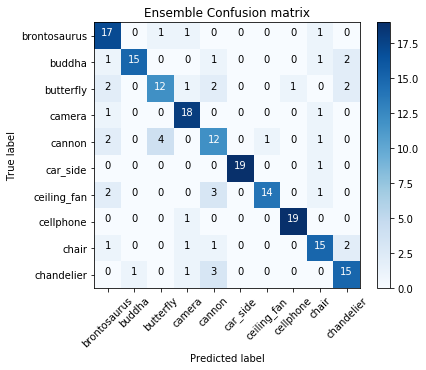

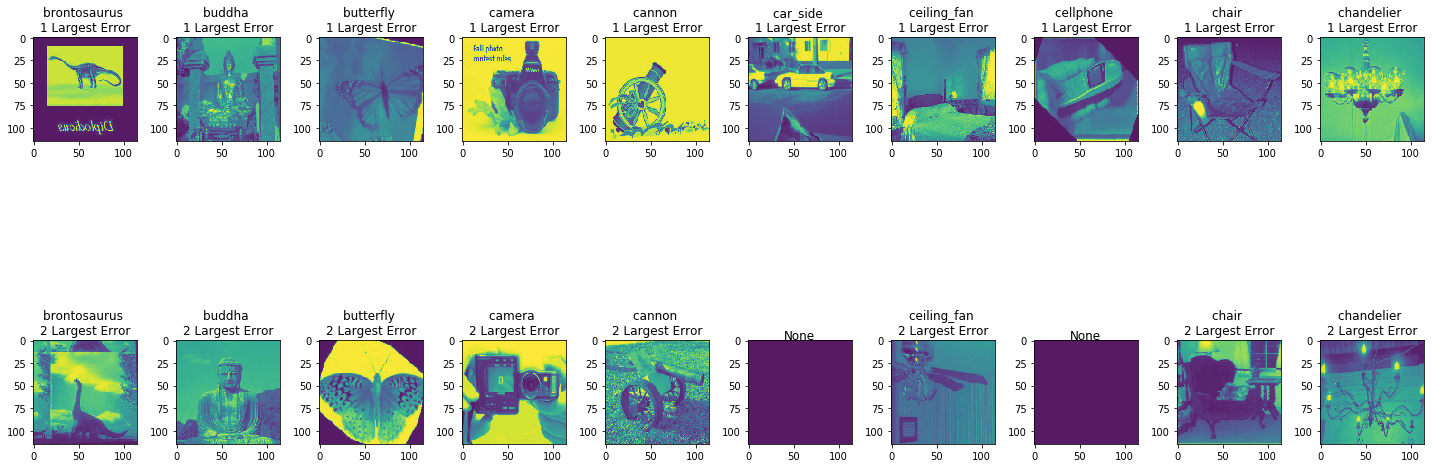

In [27]:
def main(data_path,class_indices):
    
    # Best ensemble weights configuration
    best_params_ensemble = {"NBNN-Weight":0.68,
                            "SVM-Weight":0.32}
    
    # Execute 2-Pipe Based Ensemble Model
    Results = ensembleClassifier(data_path, class_indices, best_params_ensemble)
    
    # Present Error Analysis Grid
    CreateErrorGrid(Results)
    
if __name__ == '__main__':
    
    # Data Path to .\101_ObjectCategories directory
    data_path = r"D:\MSc Degree\Courses\1st Year\1. Learning, representation, and Computer Vision\Task 1\101_ObjectCategories"

    # Fold-2 classes indices
    Fold_2_class_indices = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

    # Execute Ensemble Main
    main(data_path,Fold_2_class_indices)

## <u>5. Results</u>

After specifying how the ensemble weights were optimized and set up in the previous section, we evaluated our tuned ensemble model on Fold-2 classes which result in an accuracy score of 78%. In addition, the final confusion matrix achieved is described in Figure 8 below. 

<img src="Images/Fig8.jpg" width="400" height="400"></img>


Further, by using our **ErrorVisualization()** and **CreateErrorGrid()** functions we were able to present an error analysis for the top 2 (or less in case of one misclassified image or none) largest errors of misclassified images per each class. Furthermore, note that we calculated the largest errors by the following procedure: First, we extracted the misclassified images for each class. Second, since both NBNN and SVM distances were converted to probabilities vectors, we extracted the True class probability vector. Third, we extracted the maximum probabilities achieved per each misclassified sample within the classified class in order to calculate the error between the true class probability to the predicted class probability. Finally, we selected the top 2 highest errors and their images respectively. The table below presents the error analysis for each class within Fold-2 classes.

<img src="Images/Fig9.jpg" width="1000" height="1000"></img>

## <u>6. Reference</u>

[1] Boiman, O., Shechtman, E., & Irani, M. (2008, June). In defense of nearest-neighbor based image classification. In 2008 IEEE Conference on Computer Vision and Pattern Recognition (pp. 1-8). IEEE.
- http://image.ntua.gr/iva/files/BoimanShechtmanIrani_CVPR2008%20-%20In%20Defense%20of%20Nearest-Neighbor%20Based%20Image%20Classification.pdf

[2] Bosch, A., Zisserman, A., & Munoz, X. (2007, October). Image classification using random forests and ferns. In 2007 IEEE 11th international conference on computer vision (pp. 1-8). Ieee.
- https://ieeexplore.ieee.org/abstract/document/4409066


[3] Dalal, N., & Triggs, B. (2005, June). Histograms of oriented gradients for human detection.

- https://hal.inria.fr/file/index/docid/548512/filename/hog_cvpr2005.pdf

[4] Lowe, D. G. (2004). Distinctive image features from scale-invariant keypoints. International journal of computer vision, 60(2), 91-110.

- https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94